In [112]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from hagelslag.evaluation import DistributedROC, DistributedReliability
from hagelslag.evaluation import ContingencyTable
from scipy.ndimage import convolve
from scipy.spatial import cKDTree
from matplotlib import colors

from glob import glob
import xarray as xr
import os
from os.path import join

In [95]:
eval_path = "/glade/p/work/dgagne/ncar_coarse_neighbor_eval_2016/"
eval_files = sorted(os.listdir(eval_path))
eval_test = pd.read_csv(join(eval_path, eval_files[0]))
models = eval_test.columns[eval_test.columns.str.contains("mean")]
run_dates = pd.DatetimeIndex([e.split("_")[-1][:8] for e in eval_files])
thresholds = [25, 50, 75]
prob_thresholds = np.concatenate(([0, 0.01], np.arange(0.1, 1.1, 0.1), [1.05]))
brier = {}
roc = {}
for thresh in thresholds:
    brier[thresh] = pd.DataFrame(index=run_dates, columns=models, dtype=object)
    roc[thresh] = pd.DataFrame(index=run_dates, columns=models, dtype=object)
    #roc[thresh].loc[:, :] = DistributedROC()
    #brier[thresh].loc[:, :] = DistributedReliability()
for ev, eval_file in enumerate(eval_files):
    print(eval_file)
    eval_data = pd.read_csv(join(eval_path, eval_file))
    us_mask = eval_data["us_mask"] == 1
    for thresh in thresholds:
        obs = eval_data.loc[us_mask, "MESH_Max_60min_00.50_{0:2d}".format(thresh)]
        for model in models:
            brier[thresh].loc[run_dates[ev], model] = DistributedReliability(thresholds=prob_thresholds)
            brier[thresh].loc[run_dates[ev], model].update(eval_data.loc[us_mask, model], 
                                                           obs)
            roc[thresh].loc[run_dates[ev], model] = DistributedROC(thresholds=prob_thresholds)
            roc[thresh].loc[run_dates[ev], model].update(eval_data.loc[us_mask, model], 
                                                         obs)

coarse_neighbor_eval_NCAR_20160502.csv
coarse_neighbor_eval_NCAR_20160503.csv
coarse_neighbor_eval_NCAR_20160504.csv
coarse_neighbor_eval_NCAR_20160505.csv
coarse_neighbor_eval_NCAR_20160506.csv
coarse_neighbor_eval_NCAR_20160507.csv
coarse_neighbor_eval_NCAR_20160508.csv
coarse_neighbor_eval_NCAR_20160509.csv


KeyboardInterrupt: 

In [3]:
out_path = "/hail/djgagne/ncar_coarse_neighbor_scores_2016/"
for thresh in [25, 50, 75]:
    brier[thresh].to_csv(join(out_path, "ncar_2016_brier_objs_{0:02d}.csv".format(thresh)), index_label="Date")
    roc[thresh].to_csv(join(out_path, "ncar_2016_roc_objs_{0:02d}.csv".format(thresh)), index_label="Date")

NameError: name 'brier' is not defined

In [79]:
out_path = "/hail/djgagne/ncar_coarse_neighbor_scores_2016/"
brier = {}
roc = {}
for thresh in [25, 50]:
    print(thresh)
    brier_str = pd.read_csv(join(out_path, "ncar_2016_s_2_brier_objs_{0:02d}.csv".format(thresh)), index_col="Date")

    brier[thresh] = pd.DataFrame(index=pd.DatetimeIndex(brier_str.index), columns=brier_str.columns)
    print("Brier")
    for col in brier_str.columns:
        brier[thresh][col] = [DistributedReliability(input_str=s) for s in brier_str[col]]
    roc_str = pd.read_csv(join(out_path, "ncar_2016_roc_objs_{0:02d}.csv".format(thresh)), index_col="Date")
    roc[thresh] = pd.DataFrame(index=pd.DatetimeIndex(roc_str.index), columns=roc_str.columns)
    print("ROC")
    for col in roc_str.columns:
        roc[thresh][col] = [DistributedROC(input_str=s) for s in roc_str[col]]

25
Brier
ROC
50
Brier
ROC


In [80]:
fore_freq = pd.DataFrame(columns=brier[25].columns, index=brier[25].index, dtype=int)
for date in brier[25].index:
    for model in brier[25].columns:
        fore_freq.loc[date, model] = brier[25].loc[date, model].frequencies["Total_Freq"].sum()

In [21]:
ro = rel_objs[0]

In [26]:
ro.frequencies

Total_Freq  Positive_Freq
0        83624            119
1        40189            145
2        23176            159
3        18270            254
4        16256            308
5        16167            467
6        16540            607
7        18413            914
8        22295           1293
9        31158           2210
10      155841          20270
11       31439           4137
12           0              0

In [81]:
rel_objs = brier[25].sum(axis=0)
bss = rel_objs.apply(DistributedReliability.brier_skill_score)
bs = rel_objs.apply(DistributedReliability.brier_score)

In [28]:
rolling_brier["NCAR_HAIL_MAXK1_mean_25"]["2016-05-16"].brier_skill_score()

-0.09054204346333437

In [85]:

roc_objs = roc[25].sum(axis=0)
roc_objs_50 = roc[50].sum(axis=0)

In [86]:
auc = roc_objs.apply(DistributedROC.auc)
auc_50 = roc_objs_50.apply(DistributedROC.auc)

In [82]:
thresholds = np.array([x[-1] for x in bss.index.str.split("_").values])
model_names = np.array(["_".join(x[:-2]) for x in bss.index.str.split("_").values])

In [12]:
rel_objs

NCAR_HAIL_MAX2D_mean_5           Obs_Threshold:1.00;Thresholds:0.00 0.01 0.10 0...
NCAR_HAIL_MAX2D_mean_20          Obs_Threshold:1.00;Thresholds:0.00 0.01 0.10 0...
NCAR_HAIL_MAX2D_mean_25          Obs_Threshold:1.00;Thresholds:0.00 0.01 0.10 0...
NCAR_HAIL_MAX2D_mean_30          Obs_Threshold:1.00;Thresholds:0.00 0.01 0.10 0...
NCAR_HAIL_MAX2D_mean_35          Obs_Threshold:1.00;Thresholds:0.00 0.01 0.10 0...
NCAR_HAIL_MAX2D_mean_40          Obs_Threshold:1.00;Thresholds:0.00 0.01 0.10 0...
NCAR_HAIL_MAX2D_mean_45          Obs_Threshold:1.00;Thresholds:0.00 0.01 0.10 0...
NCAR_HAIL_MAX2D_mean_50          Obs_Threshold:1.00;Thresholds:0.00 0.01 0.10 0...
NCAR_HAIL_MAX2D_mean_75          Obs_Threshold:1.00;Thresholds:0.00 0.01 0.10 0...
NCAR_HAIL_MAXK1_mean_5           Obs_Threshold:1.00;Thresholds:0.00 0.01 0.10 0...
NCAR_HAIL_MAXK1_mean_20          Obs_Threshold:1.00;Thresholds:0.00 0.01 0.10 0...
NCAR_HAIL_MAXK1_mean_25          Obs_Threshold:1.00;Thresholds:0.00 0.01 0.10 0...
NCAR

NCAR_Elastic-Net
['5' '20' '25' '30' '35' '40' '45' '50' '75']
NCAR_GRPL_MAX
['5' '10' '15' '20' '25' '30' '35' '40' '45' '50']
NCAR_HAILCAST_DIAM_MEAN
['5' '20' '25' '30' '35' '40' '45' '50' '75']
NCAR_HAIL_MAX2D
['5' '20' '25' '30' '35' '40' '45' '50' '75']
NCAR_HAIL_MAXK1
['5' '20' '25' '30' '35' '40' '45' '50' '75']
NCAR_REFD_MAX
['50' '55' '60' '65' '70']
NCAR_Random-Forest
['5' '20' '25' '30' '35' '40' '45' '50' '75']
NCAR_Random-Forest-CV
['5' '20' '25' '30' '35' '40' '45' '50' '75']
NCAR_UP_HELI_MAX
['5' '25' '50' '75' '100' '125' '150' '175' '200']
NCAR_W_UP_MAX
['2' '5' '10' '20' '30' '40']


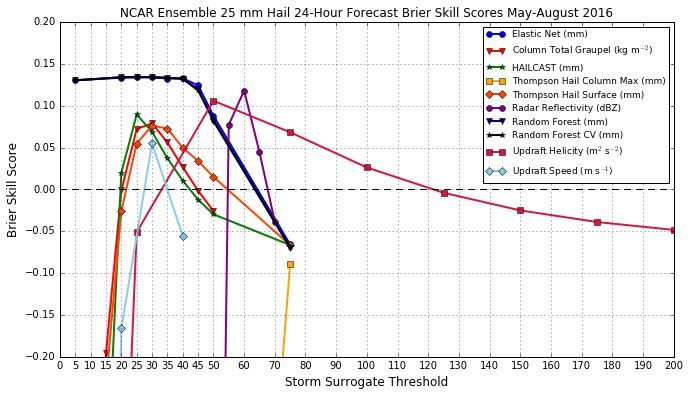

In [352]:
plt.figure(figsize=(11, 6))
colors = ["blue", "red", "green", "orange", "orangered", "purple", "navy", "black", "crimson", "skyblue"]
units = {"NCAR_Elastic-Net": "mm",
         "NCAR_Random-Forest": "mm",
         "NCAR_Random-Forest-CV": "mm",
         "NCAR_GRPL_MAX": "kg m$^{-2}$",
         "NCAR_HAILCAST_DIAM_MEAN": "mm",
         "NCAR_HAIL_MAX2D": "mm",
         "NCAR_HAIL_MAXK1": "mm",
         "NCAR_REFD_MAX": "dBZ",
         "NCAR_UP_HELI_MAX": "m$^2$ s$^{-2}$",
         "NCAR_W_UP_MAX": "m s$^{-1}$"
        }
long_names = {"NCAR_Elastic-Net": "Elastic Net",
         "NCAR_Random-Forest": "Random Forest",
         "NCAR_Random-Forest-CV": "Random Forest CV",
         "NCAR_GRPL_MAX": "Column Total Graupel",
         "NCAR_HAILCAST_DIAM_MEAN": "HAILCAST",
         "NCAR_HAIL_MAX2D": "Thompson Hail Column Max",
         "NCAR_HAIL_MAXK1": "Thompson Hail Surface",
         "NCAR_REFD_MAX": "Radar Reflectivity",
         "NCAR_UP_HELI_MAX": "Updraft Helicity",
         "NCAR_W_UP_MAX": "Updraft Speed"
        }
markers = ["o", "v", "*", "s", "D"] * 2
unique_model_names = np.sort(np.unique(model_names))
for m, model_name in enumerate(unique_model_names):
    print(model_name)
    print(thresholds[model_names == model_name])
    plt.plot(np.array(thresholds[model_names == model_name], dtype=float), 
             bss[model_names == model_name], label=long_names[model_name] + " ({0})".format(units[model_name]), 
             marker=markers[m], color=colors[m], lw=2)
    plt.plot(np.arange(200), np.zeros(200), 'k--')
plt.legend(loc=1, fontsize=9)
plt.xticks(np.concatenate((np.arange(0, 55, 5), np.arange(60, 210, 10))))
plt.grid()
plt.ylim(-0.2, 0.2)
plt.xlabel("Storm Surrogate Threshold", fontsize=12)
plt.ylabel("Brier Skill Score", fontsize=12)
plt.title("NCAR Ensemble 25 mm Hail 24-Hour Forecast Brier Skill Scores May-August 2016")
plt.savefig("ncar_ens_thresh_comp_bss_25.png", dpi=300, bbox_inches="tight")
plt.savefig("ncar_ens_thresh_comp_bss_25.pdf", dpi=300, bbox_inches="tight")

NCAR_Elastic-Net
['5' '20' '25' '30' '35' '40' '45' '50' '75']
NCAR_GRPL_MAX
['5' '10' '15' '20' '25' '30' '35' '40' '45' '50']
NCAR_HAILCAST_DIAM_MEAN
['5' '20' '25' '30' '35' '40' '45' '50' '75']
NCAR_HAIL_MAX2D
['5' '20' '25' '30' '35' '40' '45' '50' '75']
NCAR_HAIL_MAXK1
['5' '20' '25' '30' '35' '40' '45' '50' '75']
NCAR_REFD_MAX
['50' '55' '60' '65' '70']
NCAR_Random-Forest
['5' '20' '25' '30' '35' '40' '45' '50' '75']
NCAR_Random-Forest-CV
['5' '20' '25' '30' '35' '40' '45' '50' '75']
NCAR_UP_HELI_MAX
['5' '25' '50' '75' '100' '125' '150' '175' '200']
NCAR_W_UP_MAX
['2' '5' '10' '20' '30' '40']


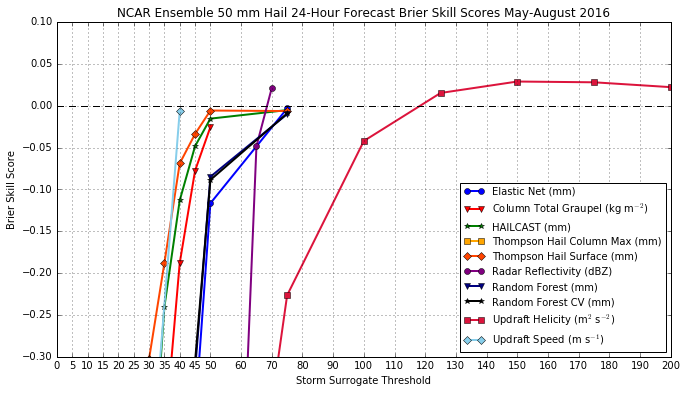

In [355]:
plt.figure(figsize=(11, 6))
for m, model_name in enumerate(unique_model_names):
    print(model_name)
    print(thresholds[model_names == model_name])
    plt.plot(np.array(thresholds[model_names == model_name], dtype=float), 
             bss_50[model_names == model_name], label=long_names[model_name] + " ({0})".format(units[model_name]), 
             marker=markers[m], color=colors[m], lw=2)
    plt.plot(np.arange(200), np.zeros(200), 'k--')
plt.legend(loc=4, fontsize=10)
plt.xticks(np.concatenate((np.arange(0, 55, 5), np.arange(60, 210, 10))))
plt.grid()
plt.ylim(-0.3, 0.1)
plt.xlabel("Storm Surrogate Threshold")
plt.ylabel("Brier Skill Score")
plt.title("NCAR Ensemble 50 mm Hail 24-Hour Forecast Brier Skill Scores May-August 2016")
plt.savefig("ncar_ens_thresh_comp_bss_50.png", dpi=300, bbox_inches="tight")
plt.savefig("ncar_ens_thresh_comp_bss_50.pdf", dpi=300, bbox_inches="tight")

NCAR_Elastic-Net
['5' '20' '25' '30' '35' '40' '45' '50' '75']
NCAR_GRPL_MAX
['5' '10' '15' '20' '25' '30' '35' '40' '45' '50']
NCAR_HAILCAST_DIAM_MEAN
['5' '20' '25' '30' '35' '40' '45' '50' '75']
NCAR_HAIL_MAX2D
['5' '20' '25' '30' '35' '40' '45' '50' '75']
NCAR_HAIL_MAXK1
['5' '20' '25' '30' '35' '40' '45' '50' '75']
NCAR_REFD_MAX
['50' '55' '60' '65' '70']
NCAR_Random-Forest
['5' '20' '25' '30' '35' '40' '45' '50' '75']
NCAR_Random-Forest-CV
['5' '20' '25' '30' '35' '40' '45' '50' '75']
NCAR_UP_HELI_MAX
['5' '25' '50' '75' '100' '125' '150' '175' '200']
NCAR_W_UP_MAX
['2' '5' '10' '20' '30' '40']


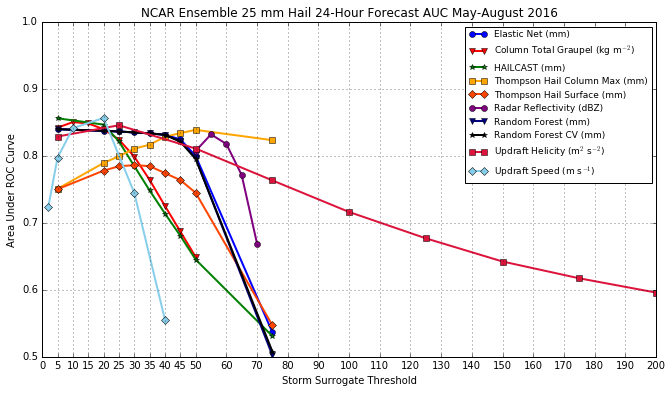

In [353]:
plt.figure(figsize=(11, 6))
colors = ["blue", "red", "green", "orange", "orangered", "purple", "navy", "black", "crimson", "skyblue"]
units = {"NCAR_Elastic-Net": "mm",
         "NCAR_Random-Forest": "mm",
         "NCAR_Random-Forest-CV": "mm",
         "NCAR_GRPL_MAX": "kg m$^{-2}$",
         "NCAR_HAILCAST_DIAM_MEAN": "mm",
         "NCAR_HAIL_MAX2D": "mm",
         "NCAR_HAIL_MAXK1": "mm",
         "NCAR_REFD_MAX": "dBZ",
         "NCAR_UP_HELI_MAX": "m$^2$ s$^{-2}$",
         "NCAR_W_UP_MAX": "m s$^{-1}$"
        }
long_names = {"NCAR_Elastic-Net": "Elastic Net",
         "NCAR_Random-Forest": "Random Forest",
         "NCAR_Random-Forest-CV": "Random Forest CV",
         "NCAR_GRPL_MAX": "Column Total Graupel",
         "NCAR_HAILCAST_DIAM_MEAN": "HAILCAST",
         "NCAR_HAIL_MAX2D": "Thompson Hail Column Max",
         "NCAR_HAIL_MAXK1": "Thompson Hail Surface",
         "NCAR_REFD_MAX": "Radar Reflectivity",
         "NCAR_UP_HELI_MAX": "Updraft Helicity",
         "NCAR_W_UP_MAX": "Updraft Speed"
        }
unique_model_names = np.sort(np.unique(model_names))
for m, model_name in enumerate(unique_model_names):
    print(model_name)
    print(thresholds[model_names == model_name])
    plt.plot(np.array(thresholds[model_names == model_name], dtype=float), 
             auc[model_names == model_name], label=long_names[model_name] + " ({0})".format(units[model_name]), 
             marker=markers[m], color=colors[m], lw=2)
    plt.plot(np.arange(200), np.zeros(200), 'k--')
plt.legend(loc=1, fontsize=9)
plt.xticks(np.concatenate((np.arange(0, 55, 5), np.arange(60, 210, 10))))
plt.grid()
plt.ylim(0.5, 1)
plt.xlabel("Storm Surrogate Threshold")
plt.ylabel("Area Under ROC Curve")
plt.title("NCAR Ensemble 25 mm Hail 24-Hour Forecast AUC May-August 2016")
plt.savefig("ncar_ens_thresh_comp_auc_25.png", dpi=300, bbox_inches="tight")
plt.savefig("ncar_ens_thresh_comp_auc_25.pdf", dpi=300, bbox_inches="tight")

NCAR_Elastic-Net
['5' '20' '25' '30' '35' '40' '45' '50' '75']
NCAR_GRPL_MAX
['5' '10' '15' '20' '25' '30' '35' '40' '45' '50']
NCAR_HAILCAST_DIAM_MEAN
['5' '20' '25' '30' '35' '40' '45' '50' '75']
NCAR_HAIL_MAX2D
['5' '20' '25' '30' '35' '40' '45' '50' '75']
NCAR_HAIL_MAXK1
['5' '20' '25' '30' '35' '40' '45' '50' '75']
NCAR_REFD_MAX
['50' '55' '60' '65' '70']
NCAR_Random-Forest
['5' '20' '25' '30' '35' '40' '45' '50' '75']
NCAR_Random-Forest-CV
['5' '20' '25' '30' '35' '40' '45' '50' '75']
NCAR_UP_HELI_MAX
['5' '25' '50' '75' '100' '125' '150' '175' '200']
NCAR_W_UP_MAX
['2' '5' '10' '20' '30' '40']


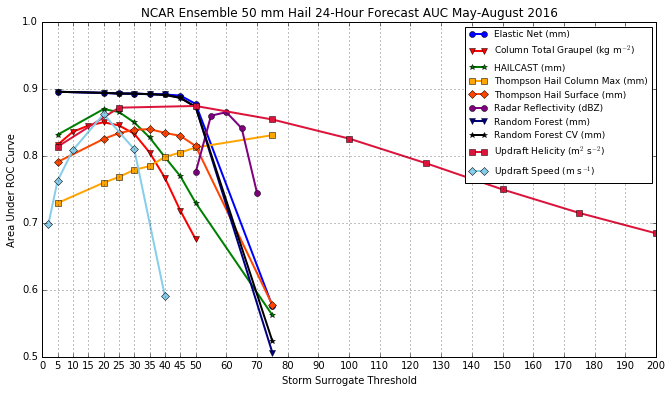

In [354]:
plt.figure(figsize=(11, 6))
colors = ["blue", "red", "green", "orange", "orangered", "purple", "navy", "black", "crimson", "skyblue"]
units = {"NCAR_Elastic-Net": "mm",
         "NCAR_Random-Forest": "mm",
         "NCAR_Random-Forest-CV": "mm",
         "NCAR_GRPL_MAX": "kg m$^{-2}$",
         "NCAR_HAILCAST_DIAM_MEAN": "mm",
         "NCAR_HAIL_MAX2D": "mm",
         "NCAR_HAIL_MAXK1": "mm",
         "NCAR_REFD_MAX": "dBZ",
         "NCAR_UP_HELI_MAX": "m$^2$ s$^{-2}$",
         "NCAR_W_UP_MAX": "m s$^{-1}$"
        }
long_names = {"NCAR_Elastic-Net": "Elastic Net",
         "NCAR_Random-Forest": "Random Forest",
         "NCAR_Random-Forest-CV": "Random Forest CV",
         "NCAR_GRPL_MAX": "Column Total Graupel",
         "NCAR_HAILCAST_DIAM_MEAN": "HAILCAST",
         "NCAR_HAIL_MAX2D": "Thompson Hail Column Max",
         "NCAR_HAIL_MAXK1": "Thompson Hail Surface",
         "NCAR_REFD_MAX": "Radar Reflectivity",
         "NCAR_UP_HELI_MAX": "Updraft Helicity",
         "NCAR_W_UP_MAX": "Updraft Speed"
        }
unique_model_names = np.sort(np.unique(model_names))
for m, model_name in enumerate(unique_model_names):
    print(model_name)
    print(thresholds[model_names == model_name])
    plt.plot(np.array(thresholds[model_names == model_name], dtype=float), 
             auc_50[model_names == model_name], label=long_names[model_name] + " ({0})".format(units[model_name]), 
             marker=markers[m], color=colors[m], lw=2)
    plt.plot(np.arange(200), np.zeros(200), 'k--')
plt.legend(loc=1, fontsize=9)
plt.xticks(np.concatenate((np.arange(0, 55, 5), np.arange(60, 210, 10))))
plt.grid()
plt.ylim(0.5, 1)
plt.xlabel("Storm Surrogate Threshold")
plt.ylabel("Area Under ROC Curve")
plt.title("NCAR Ensemble 50 mm Hail 24-Hour Forecast AUC May-August 2016")
plt.savefig("ncar_ens_thresh_comp_auc_50.png", dpi=300, bbox_inches="tight")
plt.savefig("ncar_ens_thresh_comp_auc_50.pdf", dpi=300, bbox_inches="tight")

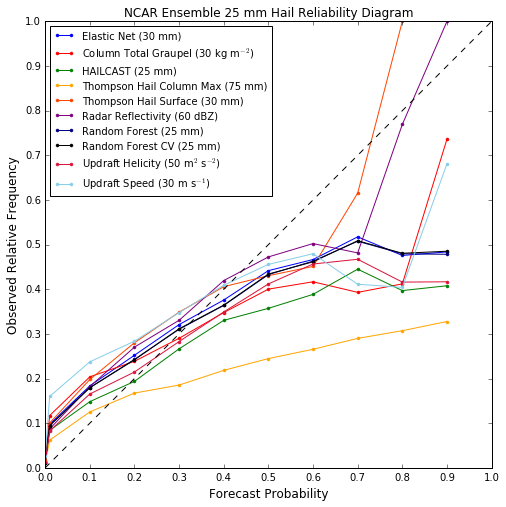

In [89]:
fig, ax = plt.subplots(figsize=(8, 8))
for m, model_name in enumerate(unique_model_names):
    max_thresh = thresholds[model_names == model_name][bss[model_names == model_name].values.argmax()]
    rel_objs.loc[model_name + "_mean_" + max_thresh].reliability_curve().plot(x="Bin_Start", 
                                                                              y="Positive_Relative_Freq",
                                                                             color=colors[m],
                                                                             marker='.',
                                                                              ax=ax,
                                                                             xlim=(0, 1),
                                                                             ylim=(0, 1),
                                                                             label=long_names[model_name] + " ({0} {1})".format(max_thresh, units[model_name]))
plt.xlabel("Forecast Probability", fontsize=12)
plt.ylabel("Observed Relative Frequency", fontsize=12)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), 'k--')
plt.legend(loc=0, fontsize=10)
plt.title("NCAR Ensemble 25 mm Hail Reliability Diagram")
plt.savefig("ncar_ens_rel_diag_25.png", dpi=300, bbox_inches="tight")
plt.savefig("ncar_ens_rel_diag_25.pdf", dpi=300, bbox_inches="tight")

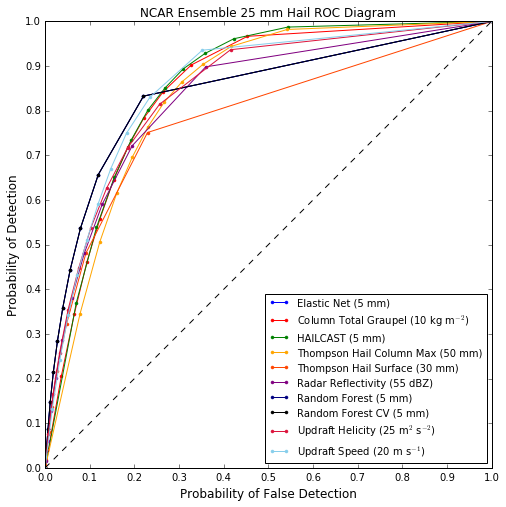

In [90]:
fig, ax = plt.subplots(figsize=(8, 8))
for m, model_name in enumerate(unique_model_names):
    max_thresh = thresholds[model_names == model_name][auc[model_names == model_name].values.argmax()]
    roc_objs.loc[model_name + "_mean_" + max_thresh].roc_curve().plot(x="POFD", 
                                                                      y="POD",
                                                                             color=colors[m],
                                                                             marker='.',
                                                                              ax=ax,
                                                                             xlim=(0, 1),
                                                                             ylim=(0, 1),
                                                                             label=long_names[model_name] + " ({0} {1})".format(max_thresh, units[model_name]))
plt.xlabel("Probability of False Detection", fontsize=12)
plt.ylabel("Probability of Detection", fontsize=12)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), 'k--')
plt.legend(loc=0, fontsize=10)
plt.title("NCAR Ensemble 25 mm Hail ROC Diagram")
plt.savefig("ncar_ens_roc_diag_25.png", dpi=300, bbox_inches="tight")
plt.savefig("ncar_ens_roc_diag_25.pdf", dpi=300, bbox_inches="tight")

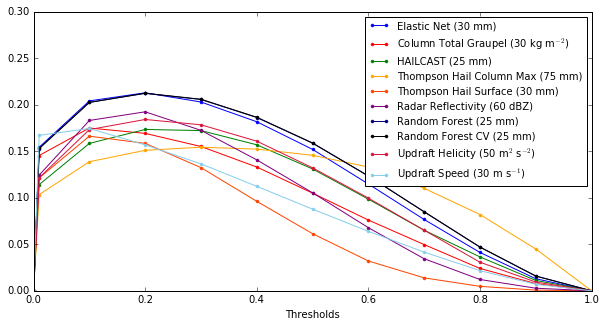

In [123]:
fig, ax = plt.subplots(figsize=(10, 5))
colors = ["blue", "red", "green", "orange", "orangered", "purple", "navy", "black", "crimson", "skyblue"]

for m, model_name in enumerate(unique_model_names):
    max_thresh = thresholds[model_names == model_name][bss[model_names == model_name].values.argmax()]
    rc = roc_objs.loc[model_name + "_mean_" + max_thresh].roc_curve()
    rc["PSS"] = rc["POD"] - rc["POFD"]
    rc["CT"] = roc_objs[model_name + "_mean_" + max_thresh].get_contingency_tables()
    rc["ETS"] = rc["CT"].apply(ContingencyTable.ets)
    rc.plot(x="Thresholds", 
            y="ETS",
            color=colors[m],
            marker='.',
            ax=ax,
            xlim=(0, 1),
            ylim=(0, 0.3),
            label=long_names[model_name] + " ({0} {1})".format(max_thresh, units[model_name]))
plt.legend(loc=0, fontsize=10)


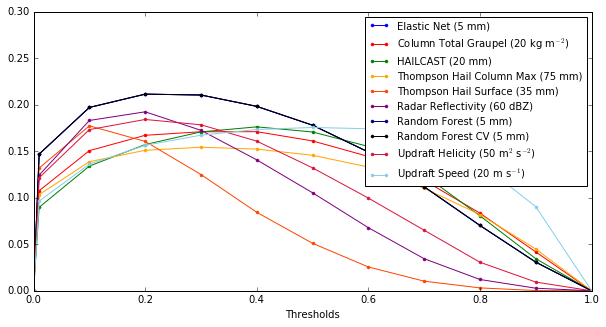

In [236]:
fig, ax = plt.subplots(figsize=(10, 5))
colors = ["blue", "red", "green", "orange", "orangered", "purple", "navy", "black", "crimson", "skyblue"]

for m, model_name in enumerate(unique_model_names):
    max_thresh = thresholds[model_names == model_name][auc_50[model_names == model_name].values.argmax()]
    rc = roc_objs_50.loc[model_name + "_mean_" + max_thresh].roc_curve()
    rc["PSS"] = rc["POD"] - rc["POFD"]
    rc["CT"] = roc_objs[model_name + "_mean_" + max_thresh].get_contingency_tables()
    rc["ETS"] = rc["CT"].apply(ContingencyTable.ets)
    rc.plot(x="Thresholds", 
            y="ETS",
            color=colors[m],
            marker='.',
            ax=ax,
            xlim=(0, 1),
            ylim=(0, 0.3),
            label=long_names[model_name] + " ({0} {1})".format(max_thresh, units[model_name]))
plt.legend(loc=0, fontsize=10)


In [70]:
roc_objs.iloc[0].performance_curve()

POD       FAR  Thresholds
0   1.000000  0.934759        0.00
1   0.996147  0.921066        0.01
2   0.991452  0.912406        0.10
3   0.986303  0.906673        0.20
4   0.978079  0.901963        0.30
5   0.968105  0.897558        0.40
6   0.952984  0.893244        0.50
7   0.933329  0.888773        0.60
8   0.903733  0.884062        0.70
9   0.861866  0.878148        0.80
10  0.790305  0.869676        0.90
11  0.133957  0.868412        1.00
12  0.000000       NaN        1.05

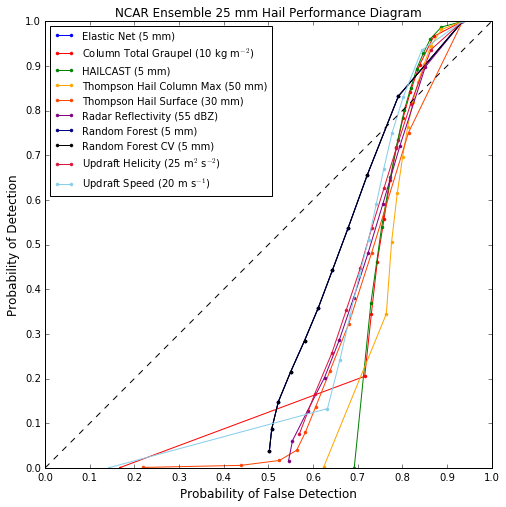

In [91]:
fig, ax = plt.subplots(figsize=(8, 8))
for m, model_name in enumerate(unique_model_names):
    max_thresh = thresholds[model_names == model_name][auc[model_names == model_name].values.argmax()]
    roc_objs.loc[model_name + "_mean_" + max_thresh].performance_curve().plot(x="FAR", 
                                                                              y="POD",
                                                                             color=colors[m],
                                                                             marker='.',
                                                                              ax=ax,
                                                                             xlim=(0, 1),
                                                                             ylim=(0, 1),
                                                                             label=long_names[model_name] + " ({0} {1})".format(max_thresh, units[model_name]))
plt.xlabel("Probability of False Detection", fontsize=12)
plt.ylabel("Probability of Detection", fontsize=12)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), 'k--')
plt.legend(loc=0, fontsize=10)
plt.title("NCAR Ensemble 25 mm Hail Performance Diagram")
plt.savefig("ncar_ens_perf_diag_25.png", dpi=300, bbox_inches="tight")
plt.savefig("ncar_ens_perf_diag_25.pdf", dpi=300, bbox_inches="tight")

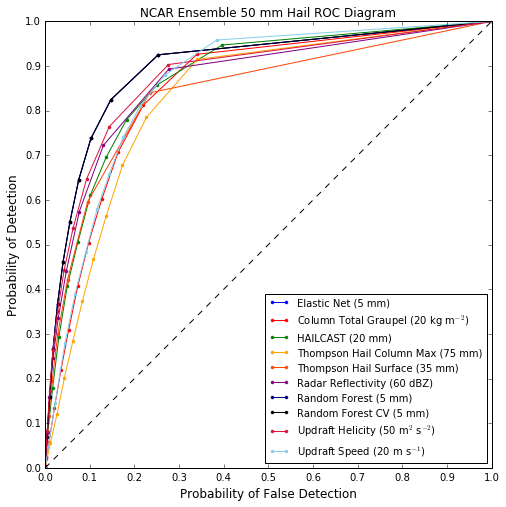

In [92]:
fig, ax = plt.subplots(figsize=(8, 8))
for m, model_name in enumerate(unique_model_names):
    max_thresh = thresholds[model_names == model_name][auc_50[model_names == model_name].values.argmax()]
    roc_objs_50.loc[model_name + "_mean_" + max_thresh].roc_curve().plot(x="POFD", 
                                                                      y="POD",
                                                                             color=colors[m],
                                                                             marker='.',
                                                                              ax=ax,
                                                                             xlim=(0, 1),
                                                                             ylim=(0, 1),
                                                                             label=long_names[model_name] + " ({0} {1})".format(max_thresh, units[model_name]))
plt.xlabel("Probability of False Detection", fontsize=12)
plt.ylabel("Probability of Detection", fontsize=12)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), 'k--')
plt.legend(loc=0, fontsize=10)
plt.title("NCAR Ensemble 50 mm Hail ROC Diagram")
plt.savefig("ncar_ens_roc_diag_50.png", dpi=300, bbox_inches="tight")
plt.savefig("ncar_ens_roc_diag_50.pdf", dpi=300, bbox_inches="tight")

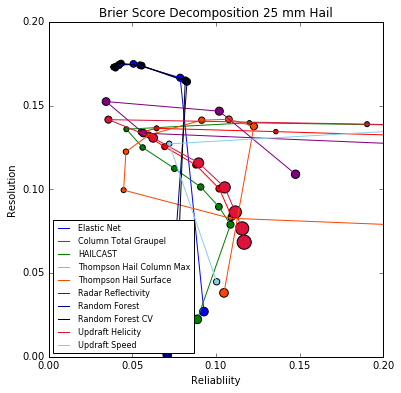

In [93]:
plt.figure(figsize=(6, 6))
for m, model_name in enumerate(unique_model_names):
    num_thresh = np.count_nonzero(model_names == model_name)
    model_thresh = thresholds[model_names == model_name]
    bs_comps = np.zeros((num_thresh, 3))
    for t in range(num_thresh):
        bs_comps[t] = rel_objs.loc[model_name + "_mean_" + model_thresh[t]].brier_score_components()
    plt.plot(bs_comps[:, 0] / bs_comps[:, 2], bs_comps[:, 1] / bs_comps[:, 2], 
             label=long_names[model_name], marker='', color=colors[m])
    plt.scatter(bs_comps[:, 0] / bs_comps[:, 2], bs_comps[:, 1] / bs_comps[:, 2], model_thresh.astype(float), colors[m],
             )
plt.xlim(0, 0.2)
plt.ylim(0, 0.2)
plt.legend(loc=0, fontsize=8)
plt.xlabel("Reliabliity")
plt.ylabel("Resolution")
plt.title("Brier Score Decomposition 25 mm Hail")
plt.savefig("ncar_ens_bs_decomp.pdf", bbox_inches="tight")

In [32]:
total_freqs = np.zeros(len(rel_objs),dtype=int)
for r, ro in enumerate(rel_objs_50.values):
    total_freqs[r] = ro.frequencies["Total_Freq"].sum()
    if total_freqs[r] < 473368:
        print(rel_objs.index[r], total_freqs[r])

In [64]:
total_freqs

array([441929, 469914, 471101, 472059, 472439, 472987, 473169, 473283,
       473368, 473071, 473368, 473368, 473368, 473368, 473368, 473368,
       473368, 473368, 473288, 473368, 473368, 473368, 473368, 473368,
       473368, 473368, 473368, 473296, 473362, 473368, 473368, 473368,
       473368, 473368, 473368, 473368, 473368, 473329, 473368, 473368,
       473368, 473368, 473368, 473368, 473368, 473368, 445254, 469766,
       472961, 473361, 473368, 473368, 473295, 473368, 473368, 473368,
       473368, 473368, 473368, 473368, 473368, 473368, 473368, 473368,
       473368, 473368, 473368, 473368, 473368, 473368, 473368, 473368,
       473368, 473368, 473368, 473368, 473368, 473368, 473368, 473368,
       473368, 473368, 473368, 473368])

In [51]:
ro = rel_objs.iloc[6]
rc = rel_objs.iloc[6].reliability_curve()
print ro.brier_score_components()
print ro.frequencies["Total_Freq"].sum()
print np.sum(ro.frequencies["Total_Freq"] * (rc["Bin_Start"] - rc["Positive_Relative_Freq"]) ** 2) / ro.frequencies["Total_Freq"].sum()

(0.11235548880560145, 0.006150279667051211, 0.06088900772688263)
473169
0.112355488806


In [94]:
rel_objs_50 = brier[50].sum(axis=0)
bss_50 = rel_objs_50.apply(DistributedReliability.brier_skill_score)


In [63]:
rel_objs.loc["NCAR_UP_HELI_MAX_mean_100"].reliability_curve()

Bin_Start  Bin_End  Bin_Center  Positive_Relative_Freq  \
0        0.00     0.01       0.005                0.035754   
1        0.01     0.10       0.055                0.190409   
2        0.10     0.20       0.150                0.289135   
3        0.20     0.30       0.250                0.369269   
4        0.30     0.40       0.350                0.416542   
5        0.40     0.50       0.450                0.420709   
6        0.50     0.60       0.550                0.473643   
7        0.60     0.70       0.650                0.476364   
8        0.70     0.80       0.750                0.569149   
9        0.80     0.90       0.850                0.672727   
10       0.90     1.00       0.950                0.666667   
11       1.00     1.05       1.025                     NaN   

    Total_Relative_Freq  
0              0.866901  
1              0.079427  
2              0.024615  
3              0.011934  
4              0.007075  
5              0.004529  
6              0.002725  
7              0.001743  
8              0.000794  
9              0.000232  
10             0.000025  
11             0.000000

In [43]:
cmap = colors.ListedColormap(['white', 'red'])
bounds=[0,5,10]
norm = colors.BoundaryNorm(bounds, cmap.N)

In [50]:
cmap = plt.get_cmap("Reds")
vals = cmap(np.linspace(0, 1, 5))
vals

array([[ 1.        ,  0.96078432,  0.94117647,  1.        ],
       [ 0.98823529,  0.7320723 ,  0.62992697,  1.        ],
       [ 0.98357555,  0.41279508,  0.28835065,  1.        ],
       [ 0.7925721 ,  0.0932872 ,  0.11298731,  1.        ],
       [ 0.40392157,  0.        ,  0.05098039,  1.        ]])

In [97]:
print(unique_model_names)
model_name = "NCAR_UP_HELI_MAX"
for model_name in unique_model_names:
    model_thresh = thresholds[model_names == model_name]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    cmap = plt.get_cmap("inferno")
    cvals = cmap(np.linspace(0.1, 0.9, len(model_thresh)))
    for m, m_thresh in enumerate(model_thresh):
        rel_objs_50.loc[model_name + "_mean_" + m_thresh].reliability_curve().plot(x="Bin_Start", 
                                                                                y="Positive_Relative_Freq",
                                                                                ax=ax1,
                                                                                label=m_thresh,
                                                                               marker='.',
                                                                               color=cvals[m])
        rel_objs_50.loc[model_name + "_mean_" + m_thresh].reliability_curve().plot(x="Bin_Start", 
                                                                                y="Total_Relative_Freq",
                                                                                ax=ax2,
                                                                                label=m_thresh,
                                                                                marker='.',
                                                                               color=cvals[m])
    fig.suptitle("NCAR Ens. " + long_names[model_name] + " 50 mm Hail Forecast", fontsize=14, fontweight="bold")
    ax1.legend(fontsize=9, loc=0)
    ax2.legend_.remove()
    ax2.set_yscale("log")
    ax1.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), 'k--')
    ax1.set_xlabel("Forecast Probability", fontsize=12)
    ax1.set_ylabel("Observed Relative Frequency", fontsize=12)
    ax2.set_xlabel("Forecast Probability", fontsize=12)
    ax2.set_ylabel("Forecast Relative Frequency", fontsize=12)
    plt.savefig("ncar_hail_rel_{0}_50.pdf".format(model_name), bbox_inches="tight")
    plt.close()

['NCAR_Elastic-Net' 'NCAR_GRPL_MAX' 'NCAR_HAILCAST_DIAM_MEAN'
 'NCAR_HAIL_MAX2D' 'NCAR_HAIL_MAXK1' 'NCAR_REFD_MAX' 'NCAR_Random-Forest'
 'NCAR_Random-Forest-CV' 'NCAR_UP_HELI_MAX' 'NCAR_W_UP_MAX']


In [98]:
print(unique_model_names)
model_name = "NCAR_UP_HELI_MAX"
for model_name in unique_model_names:
    model_thresh = thresholds[model_names == model_name]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    cmap = plt.get_cmap("inferno")
    cvals = cmap(np.linspace(0.1, 0.9, len(model_thresh)))
    for m, m_thresh in enumerate(model_thresh):
        rel_objs.loc[model_name + "_mean_" + m_thresh].reliability_curve().plot(x="Bin_Start", 
                                                                                y="Positive_Relative_Freq",
                                                                                ax=ax1,
                                                                                label=m_thresh,
                                                                               marker='.',
                                                                               color=cvals[m])
        rel_objs.loc[model_name + "_mean_" + m_thresh].reliability_curve().plot(x="Bin_Start", 
                                                                                y="Total_Relative_Freq",
                                                                                ax=ax2,
                                                                                label=m_thresh,
                                                                                marker='.',
                                                                               color=cvals[m])
    fig.suptitle("NCAR Ens. " + long_names[model_name] + " 25 mm Hail Forecast", fontsize=14, fontweight="bold")
    ax1.legend(fontsize=9, loc=0)
    ax2.legend_.remove()
    ax2.set_yscale("log")
    ax1.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), 'k--')
    ax1.set_xlabel("Forecast Probability", fontsize=12)
    ax1.set_ylabel("Observed Relative Frequency", fontsize=12)
    ax2.set_xlabel("Forecast Probability", fontsize=12)
    ax2.set_ylabel("Forecast Relative Frequency", fontsize=12)
    plt.savefig("ncar_hail_rel_{0}_25.pdf".format(model_name), bbox_inches="tight")
    plt.close()

['NCAR_Elastic-Net' 'NCAR_GRPL_MAX' 'NCAR_HAILCAST_DIAM_MEAN'
 'NCAR_HAIL_MAX2D' 'NCAR_HAIL_MAXK1' 'NCAR_REFD_MAX' 'NCAR_Random-Forest'
 'NCAR_Random-Forest-CV' 'NCAR_UP_HELI_MAX' 'NCAR_W_UP_MAX']


In [329]:
print(unique_model_names)
model_name = "NCAR_UP_HELI_MAX"
for model_name in unique_model_names:
    model_thresh = thresholds[model_names == model_name]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    cmap = plt.get_cmap("viridis")
    cvals = cmap(np.linspace(0.2, 0.8, len(model_thresh)))
    for m, m_thresh in enumerate(model_thresh):
        #print(roc_objs.loc[model_name + "_mean_" + m_thresh].performance_curve())
        roc_objs.loc[model_name + "_mean_" + m_thresh].performance_curve().plot(x="FAR", 
                                                                                y="POD",
                                                                                ax=ax1,
                                                                                label=m_thresh,
                                                                               marker='.',
                                                                               color=cvals[m])
        roc_objs.loc[model_name + "_mean_" + m_thresh].roc_curve().plot(x="POFD", 
                                                                                y="POD",
                                                                                ax=ax2,
                                                                                label=m_thresh,
                                                                                marker='.',
                                                                               color=cvals[m])
    fig.suptitle("NCAR Ens. " + long_names[model_name] + " 25 mm Hail Forecast", fontsize=14, fontweight="bold")
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax1.legend(fontsize=9, loc=0)
    ax2.legend_.remove()
    #ax2.set_yscale("log")
    ax1.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), 'k--')
    ax2.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), 'k--')
    ax1.set_xlabel("False Alarm Ratio", fontsize=12)
    ax1.set_ylabel("Probability of Detection", fontsize=12)
    ax2.set_xlabel("Probability of False Detection", fontsize=12)
    ax2.set_ylabel("Probability of Detection", fontsize=12)
    plt.savefig("ncar_hail_perf_{0}_25.pdf".format(model_name), bbox_inches="tight")
    plt.close()

['NCAR_Elastic-Net' 'NCAR_GRPL_MAX' 'NCAR_HAILCAST_DIAM_MEAN'
 'NCAR_HAIL_MAX2D' 'NCAR_HAIL_MAXK1' 'NCAR_REFD_MAX' 'NCAR_Random-Forest'
 'NCAR_Random-Forest-CV' 'NCAR_UP_HELI_MAX' 'NCAR_W_UP_MAX']


In [330]:
print(unique_model_names)
model_name = "NCAR_UP_HELI_MAX"
for model_name in unique_model_names:
    model_thresh = thresholds[model_names == model_name]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    cmap = plt.get_cmap("viridis")
    cvals = cmap(np.linspace(0.2, 0.8, len(model_thresh)))
    for m, m_thresh in enumerate(model_thresh):
        #print(roc_objs.loc[model_name + "_mean_" + m_thresh].performance_curve())
        roc_objs_50.loc[model_name + "_mean_" + m_thresh].performance_curve().plot(x="FAR", 
                                                                                y="POD",
                                                                                ax=ax1,
                                                                                label=m_thresh,
                                                                               marker='.',
                                                                               color=cvals[m])
        roc_objs_50.loc[model_name + "_mean_" + m_thresh].roc_curve().plot(x="POFD", 
                                                                                y="POD",
                                                                                ax=ax2,
                                                                                label=m_thresh,
                                                                                marker='.',
                                                                               color=cvals[m])
    fig.suptitle("NCAR Ens. " + long_names[model_name] + " 50 mm Hail Forecast", fontsize=14, fontweight="bold")
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax1.legend(fontsize=9, loc=0)
    ax2.legend_.remove()
    #ax2.set_yscale("log")
    ax1.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), 'k--')
    ax2.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), 'k--')
    ax1.set_xlabel("False Alarm Ratio", fontsize=12)
    ax1.set_ylabel("Probability of Detection", fontsize=12)
    ax2.set_xlabel("Probability of False Detection", fontsize=12)
    ax2.set_ylabel("Probability of Detection", fontsize=12)
    plt.savefig("ncar_hail_perf_{0}_50.pdf".format(model_name), bbox_inches="tight")
    plt.close()

['NCAR_Elastic-Net' 'NCAR_GRPL_MAX' 'NCAR_HAILCAST_DIAM_MEAN'
 'NCAR_HAIL_MAX2D' 'NCAR_HAIL_MAXK1' 'NCAR_REFD_MAX' 'NCAR_Random-Forest'
 'NCAR_Random-Forest-CV' 'NCAR_UP_HELI_MAX' 'NCAR_W_UP_MAX']


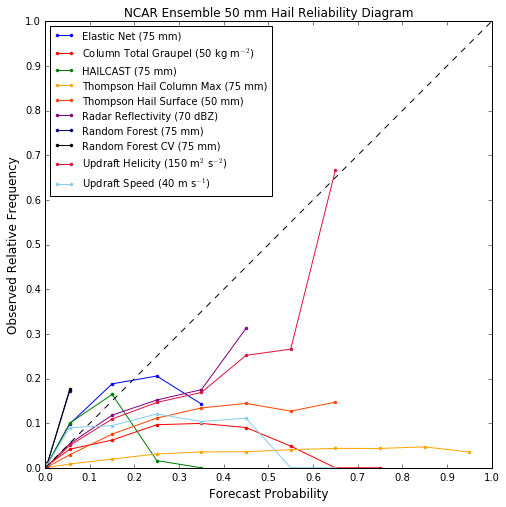

In [100]:
fig, ax = plt.subplots(figsize=(8, 8))
for m, model_name in enumerate(unique_model_names):
    max_thresh = thresholds[model_names == model_name][bss_50[model_names == model_name].values.argmax()]
    rel_objs_50.loc[model_name + "_mean_" + max_thresh].reliability_curve().plot(x="Bin_Center", 
                                                                              y="Positive_Relative_Freq",
                                                                             color=colors[m],
                                                                             marker='.',
                                                                              ax=ax,
                                                                             xlim=(0, 1),
                                                                             ylim=(0, 1),
                                                                             label=long_names[model_name] + " ({0} {1})".format(max_thresh, units[model_name]))
plt.xlabel("Forecast Probability", fontsize=12)
plt.ylabel("Observed Relative Frequency", fontsize=12)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), 'k--')
plt.legend(loc=0, fontsize=10)
plt.title("NCAR Ensemble 50 mm Hail Reliability Diagram")
plt.savefig("ncar_ens_rel_diag_50.png", dpi=300, bbox_inches="tight")
plt.savefig("ncar_ens_rel_diag_50.pdf", dpi=300, bbox_inches="tight")

In [102]:
daily_bss = pd.DataFrame(index=brier[25].index, columns=brier[25].columns)
def brier_skill_score(obj):
    try:
        return DistributedReliability.brier_skill_score(obj)
    except ZeroDivisionError:
        return np.nan
for col in daily_bss:
    daily_bss.loc[:, col] = brier[25][col].apply(brier_skill_score)

In [124]:
daily_bss

NCAR_HAIL_MAX2D_mean_5  NCAR_HAIL_MAX2D_mean_20  \
Date                                                          
2016-05-02               -7.189639                -3.270793   
2016-05-03               -7.732068                -3.666396   
2016-05-04              -19.893485               -13.280084   
2016-05-05              -27.987419               -16.942550   
2016-05-06              -12.793825                -8.239850   
2016-05-07              -18.712853               -11.122744   
2016-05-08               -8.463085                -4.644323   
2016-05-09              -10.016884                -5.720819   
2016-05-10               -5.986764                -2.764805   
2016-05-11               -3.855741                -1.522695   
2016-05-12               -8.074609                -4.944974   
2016-05-13               -6.036731                -2.028227   
2016-05-14              -14.754240                -8.116993   
2016-05-15              -20.506299               -10.912783   
2016-05-16              -19.607071                -9.463523   
2016-05-17              -15.517571                -9.247036   
2016-05-18              -16.979145               -10.076923   
2016-05-19              -19.456682               -12.934922   
2016-05-20              -20.018748               -12.142060   
2016-05-21               -9.238095                -5.402257   
2016-05-22               -8.799959                -5.030661   
2016-05-23               -6.851811                -3.561631   
2016-05-24               -4.463259                -2.995412   
2016-05-25               -3.144660                -2.240273   
2016-05-26               -5.510341                -3.931670   
2016-05-27              -14.133136               -10.644808   
2016-05-28              -12.233864                -8.249644   
2016-05-29               -6.215206                -4.099371   
2016-05-30               -7.250334                -5.174271   
2016-05-31               -4.249249                -2.603912   
...                            ...                      ...   
2016-07-24               -4.245468                -3.051894   
2016-07-25               -4.592099                -3.685633   
2016-07-26               -4.381270                -3.586136   
2016-07-27               -2.312045                -1.788261   
2016-07-29               -3.772275                -2.740234   
2016-07-30               -3.352783                -2.647906   
2016-07-31               -2.509295                -2.008433   
2016-08-01               -4.491040                -3.781949   
2016-08-02               -4.848577                -3.772925   
2016-08-03               -4.605730                -3.433696   
2016-08-04             -124.497172              -102.313327   
2016-08-08                     NaN                      NaN   
2016-08-09               -4.893963                -3.876459   
2016-08-10               -4.842153                -3.552791   
2016-08-11               -6.271590                -5.135609   
2016-08-12               -8.631229                -7.108720   
2016-08-13               -6.470542                -5.112198   
2016-08-14               -8.256518                -5.638742   
2016-08-15               -6.721215                -4.482427   
2016-08-16               -5.931578                -4.511740   
2016-08-17               -9.232286                -7.244791   
2016-08-18               -5.961433                -4.507951   
2016-08-19               -9.061334                -7.180308   
2016-08-20              -13.965997               -11.173101   
2016-08-21              -23.554797               -19.072822   
2016-08-26               -4.614852                -3.374502   
2016-08-27               -4.425721                -3.214428   
2016-08-29               -8.072105                -6.651948   
2016-08-30              -19.369704               -14.991518   
2016-08-31              -23.512379               -18.169085   

            NCAR_HAIL_MAX2D_mean_25  NCAR_

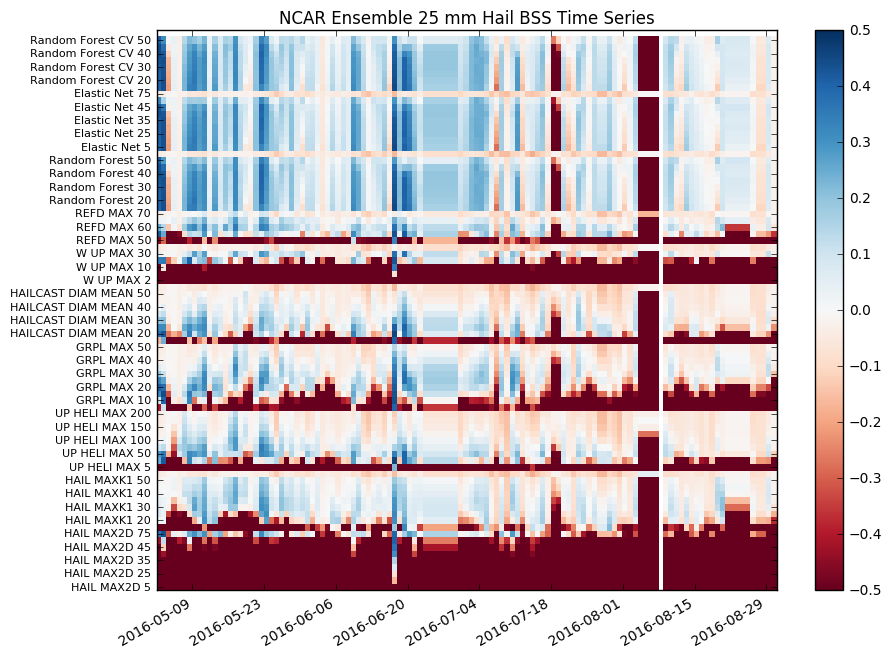

In [123]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(10, 8))
plt.pcolormesh(daily_bss.index, np.arange(0, daily_bss.shape[1]), 
               np.ma.array(daily_bss.values.T, mask=np.isnan(daily_bss.values.T)), vmin=-0.5, vmax=0.5, cmap="RdBu")
#plt.xticks(np.arange(0, daily_bss.shape[0] + 7, 7), daily_bss.index[::7], rotation=90)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.ylim(0, daily_bss.shape[1])
plt.yticks(np.arange(0.5, daily_bss.shape[1], 2), 
           daily_bss.columns[::2].str.replace("NCAR_", "").str.replace("_", " ").str.replace("mean ", "").str.replace("-", " "), fontsize=8)
plt.title("NCAR Ensemble 25 mm Hail BSS Time Series")
fig.autofmt_xdate()
plt.colorbar()
plt.savefig("ncar_bss_hail_ts.png", dpi=300, bbox_inches="tight")

NameError: name 'daily_bss' is not defined

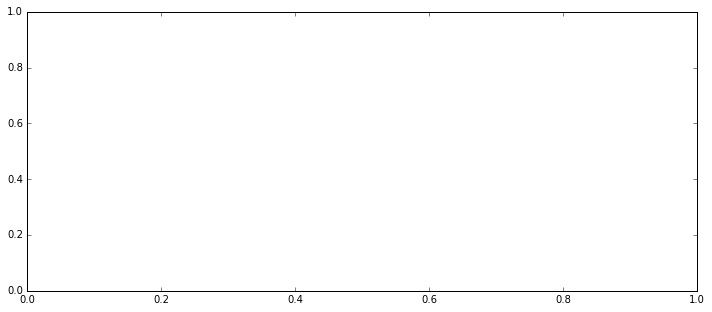

In [101]:
fig, ax = plt.subplots(figsize=(12, 5))
daily_bss.plot(y=["NCAR_Random-Forest-CV_mean_25", "NCAR_UP_HELI_MAX_mean_50", "NCAR_HAIL_MAXK1_mean_25", 
                  "NCAR_GRPL_MAX_mean_30", "NCAR_HAILCAST_DIAM_MEAN_mean_25"],
               ax=ax, marker='.', linestyle="")
plt.ylim(-1, 1)
plt.legend(loc=0, fontsize=10)
plt.grid()
plt.ylabel("Brier Skill Score")
plt.xlabel("Date")
plt.title("Daily Brier Skill Score Time Series NCAR Ens 25 mm Hail")
plt.savefig("ncar_bss_ts_hail_25.pdf", dpi=300, bbox_inches="tight")

In [154]:
eval_path = "/hail/djgagne/ncar_coarse_neighbor_eval_2016/"

eval_day = pd.read_csv(join(eval_path, "coarse_neighbor_eval_NCAR_20160804.csv"))


In [42]:
rows = eval_day.i_small.max()  + 1
cols = eval_day.j_small.max() + 1

In [81]:
dr = DistributedReliability()


In [151]:
bmap = Basemap(projection="lcc", resolution="l", lat_0=39, lon_0=-101, lat_1=32, lat_2=46,
               llcrnrlon=-120.81, llcrnrlat=23.159264, urcrnrlon=-65.02124, urcrnrlat=46.88567)

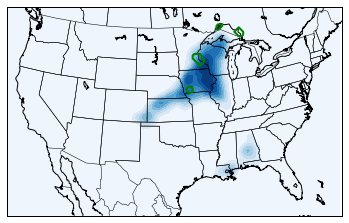

In [155]:
bmap.drawstates()
bmap.drawcountries()
bmap.drawcoastlines()
lons = eval_day.lon.values.reshape(rows, cols)
lats = eval_day.lat.values.reshape(rows, cols)
x, y = bmap(lons, lats)
plt.contourf(x,y, eval_day["NCAR_Random-Forest-CV_mean_25"].values.reshape(rows, cols), np.arange(0, 1.1, 0.1), cmap="Blues")
plt.contour(x,y, eval_day["MESH_Max_60min_00.50_25"].values.reshape(rows, cols), [0.5], colors="green", linewidths=2)

In [130]:
eval_day["NCAR_HAIL_MAX2D_mean_25"].values[eval_day["us_mask"].values == 1].max()

1.0

In [50]:
for col in eval_day.columns:
    print(col)

i
i_small
j
j_small
lat
lon
us_mask
x
y
Run_Date
Start_Date
End_Date
MESH_Max_60min_00.50_25
MESH_Max_60min_00.50_50
MESH_Max_60min_00.50_75
NCAR_HAIL_MAX2D_mem1_5
NCAR_HAIL_MAX2D_mem1_20
NCAR_HAIL_MAX2D_mem1_25
NCAR_HAIL_MAX2D_mem1_30
NCAR_HAIL_MAX2D_mem1_35
NCAR_HAIL_MAX2D_mem1_40
NCAR_HAIL_MAX2D_mem1_45
NCAR_HAIL_MAX2D_mem1_50
NCAR_HAIL_MAX2D_mem1_75
NCAR_HAIL_MAX2D_mem2_5
NCAR_HAIL_MAX2D_mem2_20
NCAR_HAIL_MAX2D_mem2_25
NCAR_HAIL_MAX2D_mem2_30
NCAR_HAIL_MAX2D_mem2_35
NCAR_HAIL_MAX2D_mem2_40
NCAR_HAIL_MAX2D_mem2_45
NCAR_HAIL_MAX2D_mem2_50
NCAR_HAIL_MAX2D_mem2_75
NCAR_HAIL_MAX2D_mem3_5
NCAR_HAIL_MAX2D_mem3_20
NCAR_HAIL_MAX2D_mem3_25
NCAR_HAIL_MAX2D_mem3_30
NCAR_HAIL_MAX2D_mem3_35
NCAR_HAIL_MAX2D_mem3_40
NCAR_HAIL_MAX2D_mem3_45
NCAR_HAIL_MAX2D_mem3_50
NCAR_HAIL_MAX2D_mem3_75
NCAR_HAIL_MAX2D_mem4_5
NCAR_HAIL_MAX2D_mem4_20
NCAR_HAIL_MAX2D_mem4_25
NCAR_HAIL_MAX2D_mem4_30
NCAR_HAIL_MAX2D_mem4_35
NCAR_HAIL_MAX2D_mem4_40
NCAR_HAIL_MAX2D_mem4_45
NCAR_HAIL_MAX2D_mem4_50
NCAR_HAIL_MAX2D_mem4_75

In [46]:
eval_day.columns[eval_day.columns.str.contains("mean")]

Index([u'NCAR_HAIL_MAX2D_mean_5', u'NCAR_HAIL_MAX2D_mean_20',
       u'NCAR_HAIL_MAX2D_mean_25', u'NCAR_HAIL_MAX2D_mean_30',
       u'NCAR_HAIL_MAX2D_mean_35', u'NCAR_HAIL_MAX2D_mean_40',
       u'NCAR_HAIL_MAX2D_mean_45', u'NCAR_HAIL_MAX2D_mean_50',
       u'NCAR_HAIL_MAX2D_mean_75', u'NCAR_HAIL_MAXK1_mean_5',
       u'NCAR_HAIL_MAXK1_mean_20', u'NCAR_HAIL_MAXK1_mean_25',
       u'NCAR_HAIL_MAXK1_mean_30', u'NCAR_HAIL_MAXK1_mean_35',
       u'NCAR_HAIL_MAXK1_mean_40', u'NCAR_HAIL_MAXK1_mean_45',
       u'NCAR_HAIL_MAXK1_mean_50', u'NCAR_HAIL_MAXK1_mean_75',
       u'NCAR_UP_HELI_MAX_mean_5', u'NCAR_UP_HELI_MAX_mean_25',
       u'NCAR_UP_HELI_MAX_mean_50', u'NCAR_UP_HELI_MAX_mean_75',
       u'NCAR_UP_HELI_MAX_mean_100', u'NCAR_UP_HELI_MAX_mean_125',
       u'NCAR_UP_HELI_MAX_mean_150', u'NCAR_UP_HELI_MAX_mean_175',
       u'NCAR_UP_HELI_MAX_mean_200', u'NCAR_GRPL_MAX_mean_5',
       u'NCAR_GRPL_MAX_mean_10', u'NCAR_GRPL_MAX_mean_15',
       u'NCAR_GRPL_MAX_mean_20', u'NCAR_GRPL_MAX_me

In [109]:
eval_day.columns

Index([u'i', u'i_small', u'j', u'j_small', u'lat', u'lon', u'us_mask', u'x',
       u'y', u'Run_Date',
       ...
       u'NCAR_Random-Forest-CV_mem2_75', u'NCAR_Random-Forest-CV_mem3_75',
       u'NCAR_Random-Forest-CV_mem4_75', u'NCAR_Random-Forest-CV_mem5_75',
       u'NCAR_Random-Forest-CV_mem6_75', u'NCAR_Random-Forest-CV_mem7_75',
       u'NCAR_Random-Forest-CV_mem8_75', u'NCAR_Random-Forest-CV_mem9_75',
       u'NCAR_Random-Forest-CV_mem10_75', u'NCAR_Random-Forest-CV_mean_75'],
      dtype='object', length=939)

In [239]:
spatial_names = ["Random Forest CV 25 mm", "HAILCAST 25 mm", "Thompson Hail 25 mm", 
                 "Column Total Graupel 30 kg m$^{-2}$", "Updraft Helicity 50 m$^2$ s$^{-2}$",
                 "Updraft Speed 30 m s$^{-1}$"]
spatial_names_50 = ["Random Forest CV 50 mm", "HAILCAST 50 mm", "Thompson Hail 50 mm", 
                 "Column Total Graupel 40 kg m$^{-2}$", "Updraft Helicity 150 m$^2$ s$^{-2}$",
                 "Updraft Speed 40 m s$^{-1}$"]

In [126]:
spatial_models = ["NCAR_Random-Forest-CV_mean_25", "NCAR_HAILCAST_DIAM_MEAN_mean_25", "NCAR_HAIL_MAXK1_mean_25", 
                  "NCAR_GRPL_MAX_mean_30", "NCAR_UP_HELI_MAX_mean_50", "NCAR_W_UP_MAX_mean_30"]
verif_var = "MESH_Max_60min_00.50_25"
eval_path = "/hail/djgagne/ncar_coarse_neighbor_eval_2016/"
eval_files = sorted(os.listdir(eval_path))
eval_test = pd.read_csv(join(eval_path, eval_files[0]))
rows = eval_test.i_small.max()  + 1
cols = eval_test.j_small.max() + 1
lon = eval_test.lon.reshape((rows, cols))
lat = eval_test.lat.reshape((rows, cols))
#models = eval_test.columns[eval_test.columns.str.contains("mean")]
run_dates = pd.DatetimeIndex([e.split("_")[-1][:8] for e in eval_files])
spatial_data = {}
for model in spatial_models:
    spatial_data[model] = np.zeros((len(run_dates), rows, cols))
spatial_verif = np.zeros((len(run_dates), rows, cols))
for e, eval_file in enumerate(eval_files):
    print(eval_file)
    eval_data = pd.read_csv(join(eval_path, eval_file))
    spatial_verif[e] = eval_data[verif_var].values.reshape(rows, cols)
    for model in spatial_models:
        spatial_data[model][e] = eval_data[model].values.reshape(rows, cols)

coarse_neighbor_eval_NCAR_20160502.csv
coarse_neighbor_eval_NCAR_20160503.csv
coarse_neighbor_eval_NCAR_20160504.csv
coarse_neighbor_eval_NCAR_20160505.csv
coarse_neighbor_eval_NCAR_20160506.csv
coarse_neighbor_eval_NCAR_20160507.csv
coarse_neighbor_eval_NCAR_20160508.csv
coarse_neighbor_eval_NCAR_20160509.csv
coarse_neighbor_eval_NCAR_20160510.csv
coarse_neighbor_eval_NCAR_20160511.csv
coarse_neighbor_eval_NCAR_20160512.csv
coarse_neighbor_eval_NCAR_20160513.csv
coarse_neighbor_eval_NCAR_20160514.csv
coarse_neighbor_eval_NCAR_20160515.csv
coarse_neighbor_eval_NCAR_20160516.csv
coarse_neighbor_eval_NCAR_20160517.csv
coarse_neighbor_eval_NCAR_20160518.csv
coarse_neighbor_eval_NCAR_20160519.csv
coarse_neighbor_eval_NCAR_20160520.csv
coarse_neighbor_eval_NCAR_20160521.csv
coarse_neighbor_eval_NCAR_20160522.csv
coarse_neighbor_eval_NCAR_20160523.csv
coarse_neighbor_eval_NCAR_20160524.csv
coarse_neighbor_eval_NCAR_20160525.csv
coarse_neighbor_eval_NCAR_20160526.csv
coarse_neighbor_eval_NCAR

In [255]:
spatial_models_50 = ["NCAR_Random-Forest-CV_mean_50", "NCAR_HAILCAST_DIAM_MEAN_mean_50", "NCAR_HAIL_MAXK1_mean_50", 
                  "NCAR_GRPL_MAX_mean_40", "NCAR_UP_HELI_MAX_mean_150", "NCAR_W_UP_MAX_mean_40"]
verif_var_50 = "MESH_Max_60min_00.50_50"
eval_path = "/hail/djgagne/ncar_coarse_neighbor_eval_2016/"
eval_files = sorted(os.listdir(eval_path))
eval_test = pd.read_csv(join(eval_path, eval_files[0]))
rows = eval_test.i_small.max()  + 1
cols = eval_test.j_small.max() + 1
lon = eval_test.lon.reshape((rows, cols))
lat = eval_test.lat.reshape((rows, cols))
#models = eval_test.columns[eval_test.columns.str.contains("mean")]
run_dates = pd.DatetimeIndex([e.split("_")[-1][:8] for e in eval_files])
spatial_data_50 = {}
for model in spatial_models_50:
    spatial_data_50[model] = np.zeros((len(run_dates), rows, cols))
spatial_verif_50 = np.zeros((len(run_dates), rows, cols))
for e, eval_file in enumerate(eval_files):
    print(eval_file)
    eval_data = pd.read_csv(join(eval_path, eval_file))
    spatial_verif_50[e] = eval_data[verif_var_50].values.reshape(rows, cols)
    for model in spatial_models_50:
        spatial_data_50[model][e] = eval_data[model].values.reshape(rows, cols)

coarse_neighbor_eval_NCAR_20160502.csv
coarse_neighbor_eval_NCAR_20160503.csv
coarse_neighbor_eval_NCAR_20160504.csv
coarse_neighbor_eval_NCAR_20160505.csv
coarse_neighbor_eval_NCAR_20160506.csv
coarse_neighbor_eval_NCAR_20160507.csv
coarse_neighbor_eval_NCAR_20160508.csv
coarse_neighbor_eval_NCAR_20160509.csv
coarse_neighbor_eval_NCAR_20160510.csv
coarse_neighbor_eval_NCAR_20160511.csv
coarse_neighbor_eval_NCAR_20160512.csv
coarse_neighbor_eval_NCAR_20160513.csv
coarse_neighbor_eval_NCAR_20160514.csv
coarse_neighbor_eval_NCAR_20160515.csv
coarse_neighbor_eval_NCAR_20160516.csv
coarse_neighbor_eval_NCAR_20160517.csv
coarse_neighbor_eval_NCAR_20160518.csv
coarse_neighbor_eval_NCAR_20160519.csv
coarse_neighbor_eval_NCAR_20160520.csv
coarse_neighbor_eval_NCAR_20160521.csv
coarse_neighbor_eval_NCAR_20160522.csv
coarse_neighbor_eval_NCAR_20160523.csv
coarse_neighbor_eval_NCAR_20160524.csv
coarse_neighbor_eval_NCAR_20160525.csv
coarse_neighbor_eval_NCAR_20160526.csv
coarse_neighbor_eval_NCAR

('NCAR_Random-Forest-CV_mean_25', 898)
('NCAR_HAILCAST_DIAM_MEAN_mean_25', 906)
('NCAR_HAIL_MAXK1_mean_25', 1248)
('NCAR_GRPL_MAX_mean_30', 650)
('NCAR_UP_HELI_MAX_mean_50', 807)
('NCAR_W_UP_MAX_mean_30', 481)


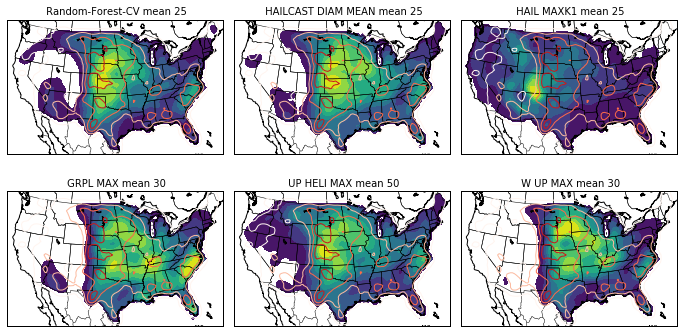

In [156]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
plt.subplots_adjust(hspace=0.05, wspace=0.05)
print(axes.ravel())
x, y = bmap(lon, lat)
us_mask = eval_test.us_mask.values.reshape(rows, cols)
verif_sum = convolve(spatial_verif.sum(axis=0) * us_mask, np.ones((5,5)))
for m, model in enumerate(spatial_models):
    bmap.drawstates(ax=axes.ravel()[m])
    bmap.drawcoastlines(ax=axes.ravel()[m])
    bmap.drawcountries(ax=axes.ravel()[m])
    spatial_sum = convolve(np.where(spatial_data[model]  * us_mask > 0.2, 1, 0).sum(axis=0), np.ones((5,5)))
    print(model, spatial_sum.max())
    axes.ravel()[m].contourf(x, y, spatial_sum * us_mask,np.linspace(20, spatial_sum.max(), 10), cmap="viridis", extend="max")
    axes.ravel()[m].set_title(model.replace("NCAR", "").replace("_", " "), fontsize=10)
    axes.ravel()[m].contour(x, y, verif_sum, 
                            np.linspace(20, verif_sum.max(), 5), cmap="Reds")
#bmap.drawstates(ax=axes.ravel()[-1])
#bmap.drawcoastlines(ax=axes.ravel()[-1])
#bmap.drawcountries(ax=axes.ravel()[-1])
#
#axes.ravel()[-1].set_title("MESH 25 mm")
plt.savefig("ncar_hail_spatial_counts.png", dpi=300, bbox_inches="tight")

('NCAR_Random-Forest-CV_mean_25', 420)
('NCAR_HAILCAST_DIAM_MEAN_mean_25', 445)
('NCAR_HAIL_MAXK1_mean_25', 493)
('NCAR_GRPL_MAX_mean_30', 343)
('NCAR_UP_HELI_MAX_mean_50', 404)
('NCAR_W_UP_MAX_mean_30', 296)


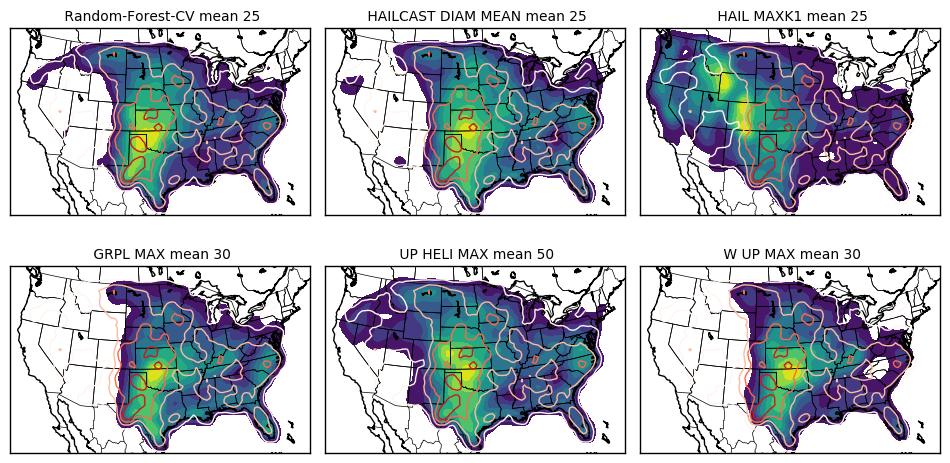

In [103]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
plt.subplots_adjust(hspace=0.05, wspace=0.05)
print(axes.ravel())
x, y = bmap(lon, lat)
us_mask = eval_test.us_mask.values.reshape(rows, cols)
verif_sum = convolve(spatial_verif[run_dates.month < 7].sum(axis=0) * us_mask, np.ones((5,5)))
for m, model in enumerate(spatial_models):
    bmap.drawstates(ax=axes.ravel()[m])
    bmap.drawcoastlines(ax=axes.ravel()[m])
    bmap.drawcountries(ax=axes.ravel()[m])
    spatial_sum = convolve(np.where(spatial_data[model][run_dates.month < 7]  * us_mask > 0.2, 1, 0).sum(axis=0), np.ones((5,5)))
    print(model, spatial_sum.max())
    axes.ravel()[m].contourf(x, y, spatial_sum,np.linspace(20, spatial_sum.max(), 10), cmap="viridis", extend="max")
    axes.ravel()[m].set_title(model.replace("NCAR", "").replace("_", " "), fontsize=10)
    axes.ravel()[m].contour(x, y, verif_sum, 
                            np.linspace(20, verif_sum.max(), 5), cmap="Reds")
#bmap.drawstates(ax=axes.ravel()[-1])
#bmap.drawcoastlines(ax=axes.ravel()[-1])
#bmap.drawcountries(ax=axes.ravel()[-1])
#
#axes.ravel()[-1].set_title("MESH 25 mm")
plt.savefig("ncar_hail_spatial_counts_may_june.png", dpi=300, bbox_inches="tight")

('NCAR_Random-Forest-CV_mean_25', 599)
('NCAR_HAILCAST_DIAM_MEAN_mean_25', 567)
('NCAR_HAIL_MAXK1_mean_25', 780)
('NCAR_GRPL_MAX_mean_30', 472)
('NCAR_UP_HELI_MAX_mean_50', 471)
('NCAR_W_UP_MAX_mean_30', 353)


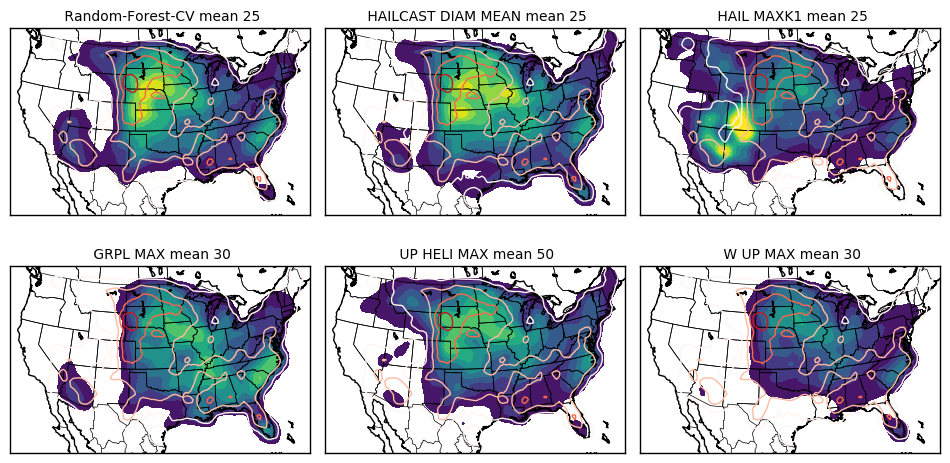

In [108]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
plt.subplots_adjust(hspace=0.05, wspace=0.05)
print(axes.ravel())
x, y = bmap(lon, lat)
us_mask = eval_test.us_mask.values.reshape(rows, cols)
verif_sum = convolve(spatial_verif[run_dates.month > 6].sum(axis=0) * us_mask, np.ones((5,5)))
for m, model in enumerate(spatial_models):
    bmap.drawstates(ax=axes.ravel()[m])
    bmap.drawcoastlines(ax=axes.ravel()[m])
    bmap.drawcountries(ax=axes.ravel()[m])
    spatial_sum = convolve(np.where(spatial_data[model][run_dates.month > 6]  * us_mask > 0.2, 1, 0).sum(axis=0), np.ones((5,5)))
    print(model, spatial_sum.max())
    axes.ravel()[m].contourf(x, y, spatial_sum,np.linspace(20, 600, 10), cmap="viridis", extend="max")
    axes.ravel()[m].set_title(model.replace("NCAR", "").replace("_", " "), fontsize=10)
    axes.ravel()[m].contour(x, y, verif_sum, 
                            np.linspace(20, 400, 5), cmap="Reds")
#bmap.drawstates(ax=axes.ravel()[-1])
#bmap.drawcoastlines(ax=axes.ravel()[-1])
#bmap.drawcountries(ax=axes.ravel()[-1])
#
#axes.ravel()[-1].set_title("MESH 25 mm")
plt.savefig("ncar_hail_spatial_counts_july_august.png", dpi=300, bbox_inches="tight")

/glade/p/work/dgagne/miniconda/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in divide
/glade/p/work/dgagne/miniconda/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in divide


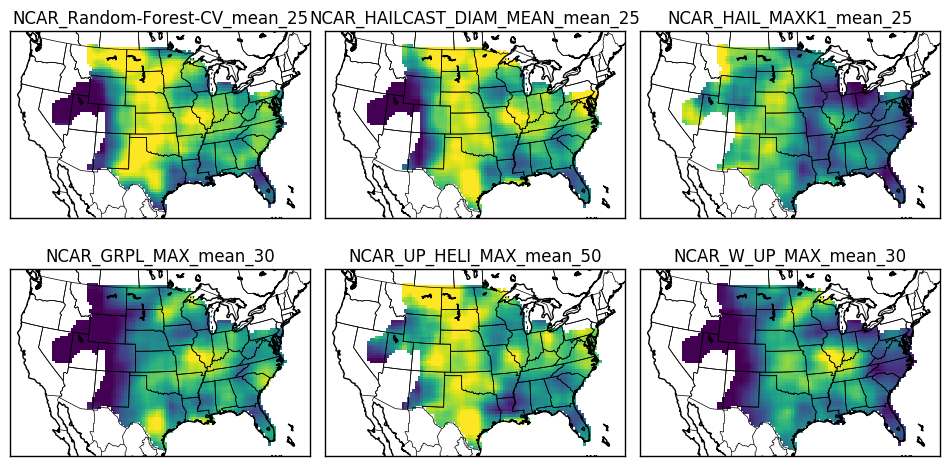

In [112]:
p_thresh = 0.3
weights = np.ones((9, 9))
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
ax_flat = axes.ravel()
plt.subplots_adjust(hspace=0.05, wspace=0.05)
for m, model in enumerate(spatial_models):
    hits = np.where((spatial_data[model][run_dates.month < 7] >= p_thresh) & (spatial_verif[run_dates.month < 7] == 1), 1, 0).sum(axis=0)
    false_alarms = np.where((spatial_data[model][run_dates.month < 7] >= p_thresh) & (spatial_verif[run_dates.month < 7] == 0), 1, 0).sum(axis=0)
    misses = np.where((spatial_data[model][run_dates.month < 7] < p_thresh) & (spatial_verif[run_dates.month < 7] == 1), 1, 0).sum(axis=0)
    tn = np.where((spatial_data[model][run_dates.month < 7] < p_thresh) & (spatial_verif[run_dates.month < 7] == 0), 1, 0).sum(axis=0)
    n_obs = convolve(spatial_verif[run_dates.month < 7].sum(axis=0), weights)
    pod = convolve(hits, weights) / convolve(hits + misses, weights).astype(float)
    far = convolve(false_alarms, weights) / convolve(hits + false_alarms, weights).astype(float)
    pofd = convolve(false_alarms, weights) / convolve(tn + false_alarms, weights).astype(float)
    bmap.drawstates(ax=ax_flat[m])
    bmap.drawcoastlines(ax=ax_flat[m])
    bmap.drawcountries(ax=ax_flat[m])
    ax_flat[m].set_title(model)
    ax_flat[m].pcolormesh(x, y, np.ma.array(pod - pofd, mask=(us_mask == 0) | (n_obs < 100)), vmin=0, vmax=0.5, cmap="viridis")

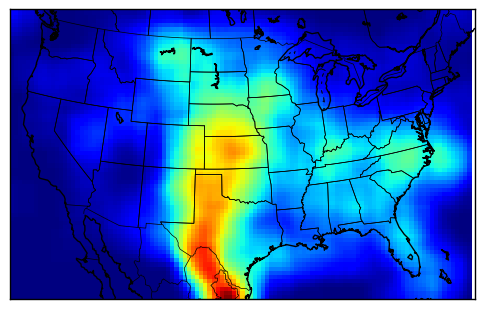

In [115]:
bmap.drawstates()
bmap.drawcoastlines()
bmap.drawcountries()
bmap.pcolormesh(x, y, n_obs)

In [278]:
ct_shape = np.concatenate([[len(spatial_models), 4], spatial_data.values()[0].shape[1:]])
spatial_ct = np.zeros(ct_shape)
sp_ct_conv = np.zeros(ct_shape)
spatial_ets = np.zeros(ct_shape[[0, 2, 3]])
c_filt = np.ones((8, 8))
p_thresh = 0.2
for m, model in enumerate(spatial_models):
    spatial_ct[m, 0] = np.where((spatial_data[model] >= p_thresh) & (spatial_verif == 1), 1, 0).sum(axis=0)
    spatial_ct[m, 1] = np.where((spatial_data[model] >= p_thresh) & (spatial_verif == 0), 1, 0).sum(axis=0)
    spatial_ct[m, 2] = np.where((spatial_data[model] < p_thresh) & (spatial_verif == 1), 1, 0).sum(axis=0)
    spatial_ct[m, 3] = np.where((spatial_data[model] < p_thresh) & (spatial_verif == 0), 1, 0).sum(axis=0)
    for t in range(4):
        sp_ct_conv[m, t] = convolve(spatial_ct[m, t] * us_mask, c_filt)
    r = (sp_ct_conv[m, 0] + sp_ct_conv[m, 1]) * (sp_ct_conv[m, 0] + sp_ct_conv[m, 2]) / sp_ct_conv[m].sum(axis=0)
    spatial_ets[m] = (sp_ct_conv[m, 0] - r) / (sp_ct_conv[m, 0:3].sum(axis=0) - r)

In [295]:
ct_shape = np.concatenate([[len(spatial_models_50), 4], spatial_data_50.values()[0].shape[1:]])
spatial_ct_50 = np.zeros(ct_shape)
sp_ct_conv = np.zeros(ct_shape)
spatial_ets_50 = np.zeros(ct_shape[[0, 2, 3]])
c_filt = np.ones((8, 8))
p_thresh = 0.2
for m, model in enumerate(spatial_models_50):
    spatial_ct_50[m, 0] = np.where((spatial_data_50[model] >= p_thresh) & (spatial_verif_50 == 1), 1, 0).sum(axis=0)
    spatial_ct_50[m, 1] = np.where((spatial_data_50[model] >= p_thresh) & (spatial_verif_50 == 0), 1, 0).sum(axis=0)
    spatial_ct_50[m, 2] = np.where((spatial_data_50[model] < p_thresh) & (spatial_verif_50 == 1), 1, 0).sum(axis=0)
    spatial_ct_50[m, 3] = np.where((spatial_data_50[model] < p_thresh) & (spatial_verif_50 == 0), 1, 0).sum(axis=0)
    for t in range(4):
        sp_ct_conv[m, t] = convolve(spatial_ct_50[m, t] * us_mask, c_filt)
    r = (sp_ct_conv[m, 0] + sp_ct_conv[m, 1]) * (sp_ct_conv[m, 0] + sp_ct_conv[m, 2]) / sp_ct_conv[m].sum(axis=0)
    spatial_ets_50[m] = (sp_ct_conv[m, 0] - r) / (sp_ct_conv[m, 0:3].sum(axis=0) - r)

['NCAR_Random-Forest-CV_mean_25', 'NCAR_HAILCAST_DIAM_MEAN_mean_25', 'NCAR_HAIL_MAXK1_mean_25', 'NCAR_GRPL_MAX_mean_30', 'NCAR_UP_HELI_MAX_mean_50', 'NCAR_W_UP_MAX_mean_30']


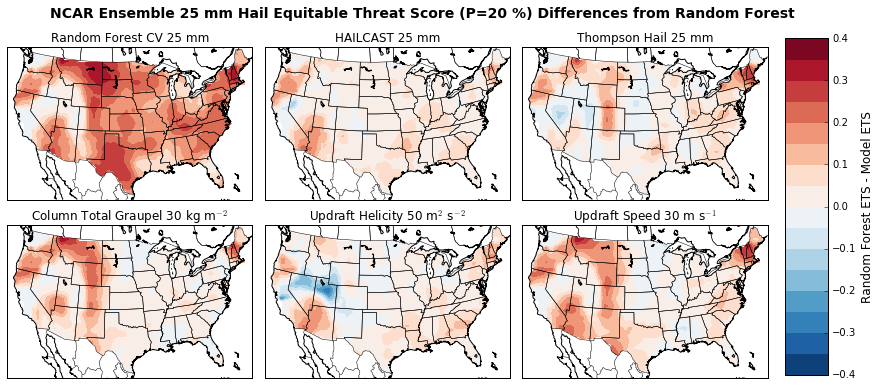

In [316]:
print(spatial_models)
fig, axes = plt.subplots(2, 3, figsize=(12, 5.5))
ax_flat = axes.ravel()
plt.subplots_adjust(0.02, 0.02, 0.9, 0.9, hspace=0.05, wspace=0.05)
for m, model in enumerate(spatial_models):
    bmap.drawstates(ax=ax_flat[m])
    bmap.drawcoastlines(ax=ax_flat[m])
    bmap.drawcountries(ax=ax_flat[m])
    if m == 0:
        ax_flat[m].contourf(x, y, np.ma.array(spatial_ets[m], mask=us_mask==0), 
                            np.linspace(-0.4, 0.4, 17), cmap="RdBu_r")
    else:
        cont = ax_flat[m].contourf(x, y, spatial_ets[0] - np.ma.array(spatial_ets[m] , mask=us_mask==0), 
                                   np.linspace(-0.4, 0.4, 17) , cmap="RdBu_r")
    ax_flat[m].set_title(spatial_names[m])
cbar_ax = fig.add_axes([0.92, 0.05, 0.05, 0.85])
cbar = fig.colorbar(cont, cax=cbar_ax)
cbar.ax.set_ylabel("Random Forest ETS - Model ETS", fontsize=12)
fig.suptitle("NCAR Ensemble 25 mm Hail Equitable Threat Score (P=20 %) Differences from Random Forest", fontsize=14, fontweight="bold")
plt.savefig("ncar_hail_spatial_ets_diff_25.pdf", bbox_inches="tight")

['NCAR_Random-Forest-CV_mean_25', 'NCAR_HAILCAST_DIAM_MEAN_mean_25', 'NCAR_HAIL_MAXK1_mean_25', 'NCAR_GRPL_MAX_mean_30', 'NCAR_UP_HELI_MAX_mean_50', 'NCAR_W_UP_MAX_mean_30']


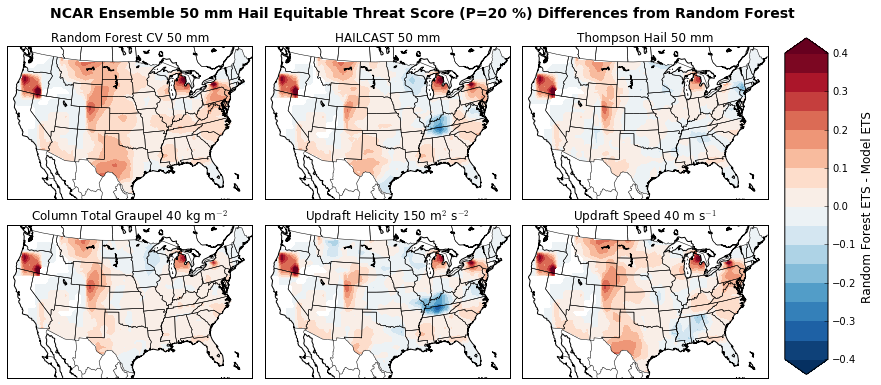

In [317]:
print(spatial_models)
fig, axes = plt.subplots(2, 3, figsize=(12, 5.5))
ax_flat = axes.ravel()
plt.subplots_adjust(0.02, 0.02, 0.9, 0.9, hspace=0.05, wspace=0.05)
for m, model in enumerate(spatial_models):
    bmap.drawstates(ax=ax_flat[m])
    bmap.drawcoastlines(ax=ax_flat[m])
    bmap.drawcountries(ax=ax_flat[m])
    if m == 0:
        ax_flat[m].contourf(x, y, np.ma.array(spatial_ets_50[m], mask=us_mask==0), 
                            np.linspace(-0.4, 0.4, 17), cmap="RdBu_r", extend="both")
    else:
        cont = ax_flat[m].contourf(x, y,np.ma.array(spatial_ets_50[0] - spatial_ets_50[m] , mask=us_mask==0), 
                                   np.linspace(-0.4, 0.4, 17) , cmap="RdBu_r", extend="both")
    ax_flat[m].set_title(spatial_names_50[m])
cbar_ax = fig.add_axes([0.92, 0.05, 0.05, 0.85])
cbar = fig.colorbar(cont, cax=cbar_ax)
cbar.ax.set_ylabel("Random Forest ETS - Model ETS", fontsize=12)
fig.suptitle("NCAR Ensemble 50 mm Hail Equitable Threat Score (P=20 %) Differences from Random Forest", fontsize=14, fontweight="bold")
plt.savefig("ncar_hail_spatial_ets_diff_50.pdf", bbox_inches="tight")

['NCAR_Random-Forest-CV_mean_25', 'NCAR_HAILCAST_DIAM_MEAN_mean_25', 'NCAR_HAIL_MAXK1_mean_25', 'NCAR_GRPL_MAX_mean_30', 'NCAR_UP_HELI_MAX_mean_50', 'NCAR_W_UP_MAX_mean_30']


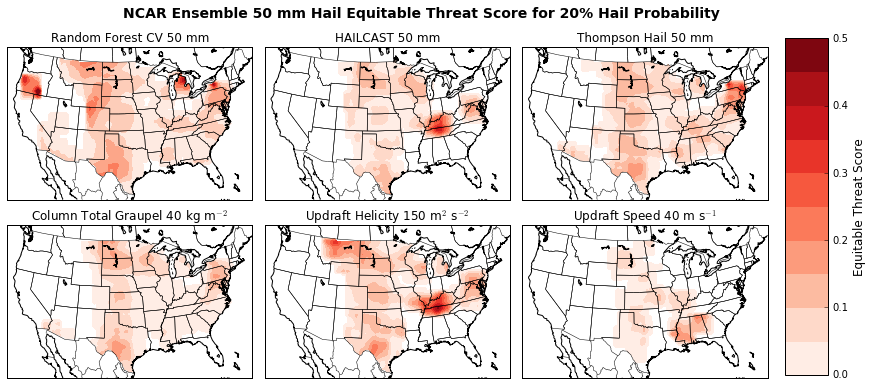

In [327]:
print(spatial_models)
fig, axes = plt.subplots(2, 3, figsize=(12, 5.5))
ax_flat = axes.ravel()
plt.subplots_adjust(0.02, 0.02, 0.9, 0.9, hspace=0.05, wspace=0.05)
for m, model in enumerate(spatial_models):
    bmap.drawstates(ax=ax_flat[m])
    bmap.drawcoastlines(ax=ax_flat[m])
    bmap.drawcountries(ax=ax_flat[m])
    if m == 0:
        ax_flat[m].contourf(x, y, np.ma.array(spatial_ets_50[m], mask=us_mask==0), 
                            np.linspace(0, 0.5, 9), cmap="Reds")
    else:
        cont = ax_flat[m].contourf(x, y,np.ma.array(spatial_ets_50[m] , mask=us_mask==0), 
                                   np.linspace(0, 0.5, 11) , cmap="Reds")
    ax_flat[m].set_title(spatial_names_50[m])
cbar_ax = fig.add_axes([0.92, 0.05, 0.05, 0.85])
cbar = fig.colorbar(cont, cax=cbar_ax)
cbar.ax.set_ylabel("Equitable Threat Score", fontsize=12)
fig.suptitle("NCAR Ensemble 50 mm Hail Equitable Threat Score for 20% Hail Probability", fontsize=14, fontweight="bold")
plt.savefig("ncar_hail_spatial_ets_50.pdf", bbox_inches="tight")

['NCAR_Random-Forest-CV_mean_25', 'NCAR_HAILCAST_DIAM_MEAN_mean_25', 'NCAR_HAIL_MAXK1_mean_25', 'NCAR_GRPL_MAX_mean_30', 'NCAR_UP_HELI_MAX_mean_50', 'NCAR_W_UP_MAX_mean_30']


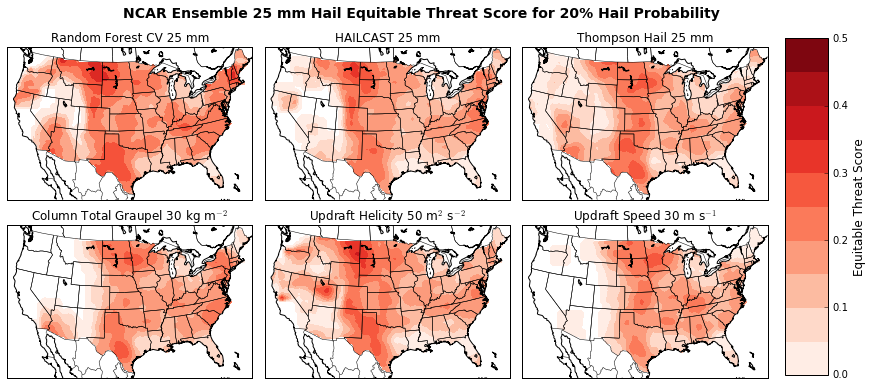

In [326]:
print(spatial_models)
fig, axes = plt.subplots(2, 3, figsize=(12, 5.5))
ax_flat = axes.ravel()
plt.subplots_adjust(0.02, 0.02, 0.9, 0.9, hspace=0.05, wspace=0.05)
for m, model in enumerate(spatial_models):
    bmap.drawstates(ax=ax_flat[m])
    bmap.drawcoastlines(ax=ax_flat[m])
    bmap.drawcountries(ax=ax_flat[m])
    if m == 0:
        ax_flat[m].contourf(x, y, np.ma.array(spatial_ets[m], mask=us_mask==0), 
                            np.linspace(0, 0.5, 9), cmap="Reds")
    else:
        cont = ax_flat[m].contourf(x, y,np.ma.array(spatial_ets[m] , mask=us_mask==0), 
                                   np.linspace(0, 0.5, 11) , cmap="Reds")
    ax_flat[m].set_title(spatial_names[m])
cbar_ax = fig.add_axes([0.92, 0.05, 0.05, 0.85])
cbar = fig.colorbar(cont, cax=cbar_ax)
cbar.ax.set_ylabel("Equitable Threat Score", fontsize=12)
fig.suptitle("NCAR Ensemble 25 mm Hail Equitable Threat Score for 20% Hail Probability", fontsize=14, fontweight="bold")
plt.savefig("ncar_hail_spatial_ets_25.pdf", bbox_inches="tight")

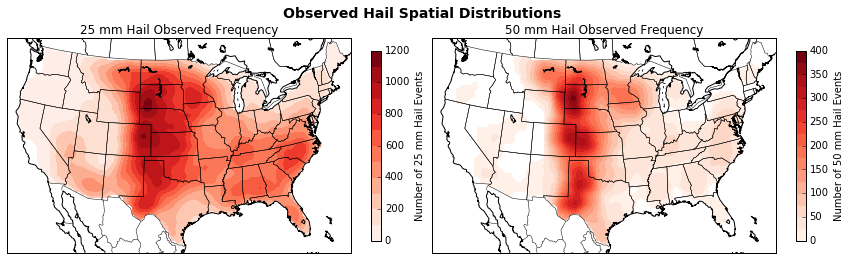

In [348]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5.5))
ax_flat = axes.ravel()
plt.subplots_adjust(0.02, 0.02, 0.98, 0.98, hspace=0.05, wspace=0.05)
spatial_count_50 = convolve(spatial_verif_50.sum(axis=0) * us_mask, c_filt)
spatial_count_25 = convolve(spatial_verif.sum(axis=0) * us_mask, c_filt)
for ax in ax_flat:
    bmap.drawstates(ax=ax)
    bmap.drawcoastlines(ax=ax)
    bmap.drawcountries(ax=ax)
cont1 = ax_flat[0].contourf(x, y, 
                            np.ma.array(spatial_count_25, mask=(us_mask==0) | (spatial_count_25 < 10)),
                            np.arange(0, 1250, 100),
                            cmap="Reds")
cont2 = ax_flat[1].contourf(x, y, 
                            np.ma.array(spatial_count_50, 
                                        mask=(us_mask==0) | (spatial_count_50  < 10)),
                           np.arange(0, spatial_count_50.max() + 25, 25),
                           cmap="Reds")
cbar1 = plt.colorbar(mappable=cont1, ax=ax_flat[0], shrink=0.5, fraction=0.1)
cbar2 = plt.colorbar(mappable=cont2, ax=ax_flat[1], shrink=0.5, fraction=0.1)
cbar1.ax.set_ylabel("Number of 25 mm Hail Events")
cbar2.ax.set_ylabel("Number of 50 mm Hail Events")
ax_flat[0].set_title("25 mm Hail Observed Frequency")
ax_flat[1].set_title("50 mm Hail Observed Frequency")
fig.suptitle("Observed Hail Spatial Distributions", y=0.85, fontsize=14, fontweight="bold")
plt.savefig("ncar_hail_spatial_obs_freq.pdf", bbox_inches="tight")